Bar chart saved to: ./oi_plots/bert_overall_oi_vs_context.jpeg


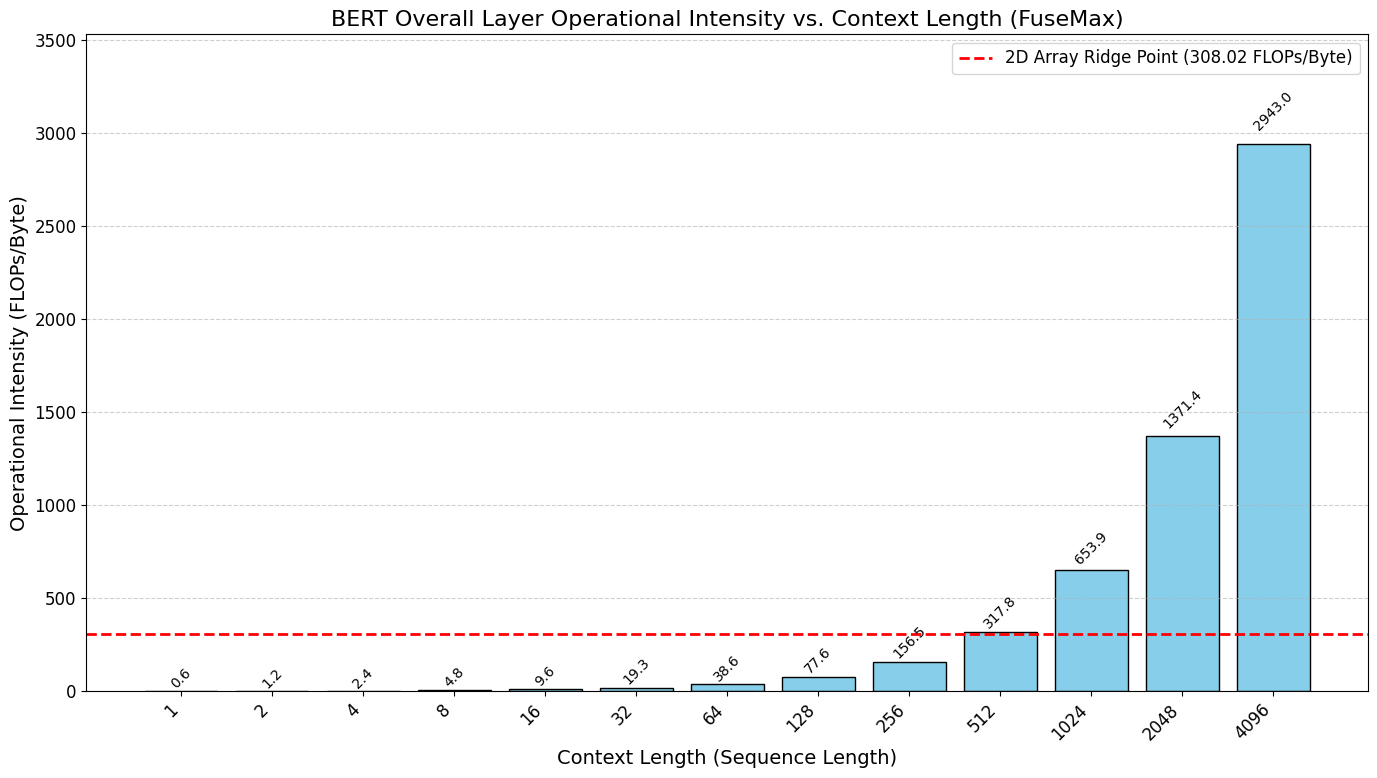

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import os

# --- Plotting Style Configuration ---
font_size_base = 14 # Adjust base font size
plt.rcParams.update({
    'font.size': font_size_base,
    'axes.titlesize': font_size_base + 2,
    'axes.labelsize': font_size_base,
    'xtick.labelsize': font_size_base - 2,
    'ytick.labelsize': font_size_base - 2,
    'legend.fontsize': font_size_base - 2, 
    'figure.titlesize': font_size_base + 4 
})
output_dir = "./oi_plots" # Optional: Define output dir if saving

# --- System Parameters (Copied from previous script) ---
MEM_BANDWIDTH_GB_s = 400  # GB/s
CLOCK_FREQ_MHZ = 940  # MHz
FLOPS_PER_PE_PER_CYCLE = 2
SRAM_CAPACITY_BYTES = 4 * 1024 * 1024 # 4MB Shared Global Buffer

# 2D PE Array
PE_ROWS_2D = 256
PE_COLS_2D = 256
NUM_PES_2D = PE_ROWS_2D * PE_COLS_2D

# --- Calculate Peak Performance & Ridge Point ---
PEAK_PERF_2D_GFLOPS = (NUM_PES_2D * FLOPS_PER_PE_PER_CYCLE * CLOCK_FREQ_MHZ) / 1000
RIDGE_POINT_2D = PEAK_PERF_2D_GFLOPS / MEM_BANDWIDTH_GB_s

# --- BERT Model Parameters ---
D_MODEL_BERT = 1024
N_HEADS_BERT = 16
D_FF_BERT = D_MODEL_BERT * 4
BYTES_PER_ELEMENT_BF16 = 2
GELU_FLOPS_PER_ELEMENT = 10 
LAYERNORM_FLOPS_PER_ELEMENT = 5

# --- Helper function (Copied & adapted from previous script) ---
def calculate_bert_overall_layer_fusemax(n_seq, d_model, n_heads, d_ff):
    """Calculates FLOPs and Bytes for BERT Overall Layer (FuseMax),
       considering SRAM capacity for weights."""
    d_head = d_model // n_heads
    debug_prints = False # Set to True to see SRAM penalty messages

    # 1. Attention Core FLOPs
    flops_qk_av_per_head = 2 * (n_seq**2 * d_head)
    flops_softmax_per_head = 3 * (n_seq**2)
    total_flops_core_attn = n_heads * (flops_qk_av_per_head * 2 + flops_softmax_per_head)
    
    # 2. MLP FLOPs & Adjusted Weight Bytes
    flops_gemm1_mlp = 2 * n_seq * d_ff * d_model
    flops_activation_mlp = GELU_FLOPS_PER_ELEMENT * n_seq * d_ff
    flops_gemm2_mlp = 2 * n_seq * d_model * d_ff
    total_flops_mlp = flops_gemm1_mlp + flops_activation_mlp + flops_gemm2_mlp
    
    mlp_gemm1_weight_bytes = d_model * d_ff * BYTES_PER_ELEMENT_BF16
    mlp_gemm2_weight_bytes = d_ff * d_model * BYTES_PER_ELEMENT_BF16
    
    adjusted_mlp_gemm1_w_bytes = mlp_gemm1_weight_bytes
    if mlp_gemm1_weight_bytes > SRAM_CAPACITY_BYTES:
        penalty_factor1 = mlp_gemm1_weight_bytes / SRAM_CAPACITY_BYTES
        adjusted_mlp_gemm1_w_bytes = mlp_gemm1_weight_bytes * penalty_factor1
        if debug_prints: print(f"INFO: BERT MLP GEMM1 weights ({mlp_gemm1_weight_bytes/1024/1024:.2f}MB) exceed SRAM ({SRAM_CAPACITY_BYTES/1024/1024:.2f}MB). Penalty: {penalty_factor1:.2f}x")

    adjusted_mlp_gemm2_w_bytes = mlp_gemm2_weight_bytes
    if mlp_gemm2_weight_bytes > SRAM_CAPACITY_BYTES:
        penalty_factor2 = mlp_gemm2_weight_bytes / SRAM_CAPACITY_BYTES
        adjusted_mlp_gemm2_w_bytes = mlp_gemm2_weight_bytes * penalty_factor2
        if debug_prints: print(f"INFO: BERT MLP GEMM2 weights ({mlp_gemm2_weight_bytes/1024/1024:.2f}MB) exceed SRAM ({SRAM_CAPACITY_BYTES/1024/1024:.2f}MB). Penalty: {penalty_factor2:.2f}x")

    bytes_mlp_weights_total_adjusted = adjusted_mlp_gemm1_w_bytes + adjusted_mlp_gemm2_w_bytes
    
    # 3. Overall Layer FLOPs & Adjusted Weight/Activation Bytes
    flops_attn_projections = 4 * (2 * n_seq * d_model**2) 
    flops_layernorm_op = LAYERNORM_FLOPS_PER_ELEMENT * n_seq * d_model
    total_flops_overall = flops_attn_projections + total_flops_core_attn + total_flops_mlp + 2 * flops_layernorm_op
    
    one_attn_proj_weight_bytes = (d_model**2) * BYTES_PER_ELEMENT_BF16
    adjusted_one_attn_proj_w_bytes = one_attn_proj_weight_bytes
    if one_attn_proj_weight_bytes > SRAM_CAPACITY_BYTES:
        penalty_factor_attn = one_attn_proj_weight_bytes / SRAM_CAPACITY_BYTES
        adjusted_one_attn_proj_w_bytes = one_attn_proj_weight_bytes * penalty_factor_attn
        if debug_prints: print(f"INFO: BERT Attn Proj weights ({one_attn_proj_weight_bytes/1024/1024:.2f}MB per proj) exceed SRAM ({SRAM_CAPACITY_BYTES/1024/1024:.2f}MB). Penalty: {penalty_factor_attn:.2f}x")

    bytes_overall_weights_attn_proj_adjusted = adjusted_one_attn_proj_w_bytes * 4
    bytes_overall_activations = (2 * n_seq * d_model) * BYTES_PER_ELEMENT_BF16
    total_bytes_overall = bytes_overall_activations + bytes_overall_weights_attn_proj_adjusted + bytes_mlp_weights_total_adjusted
    
    return total_flops_overall, total_bytes_overall

# --- Calculate OI for different context lengths ---
context_lengths = [2**i for i in range(13)] # 1, 2, 4, ..., 4096
operational_intensities = []

for n_seq in context_lengths:
    flops, bytes_val = calculate_bert_overall_layer_fusemax(
        n_seq, D_MODEL_BERT, N_HEADS_BERT, D_FF_BERT
    )
    if bytes_val > 0:
        oi = flops / bytes_val
    else:
        oi = 0 # Assign 0 OI if bytes are zero (shouldn't happen here)
    operational_intensities.append(oi)
    # print(f"Context Length: {n_seq}, FLOPs: {flops:.2e}, Bytes: {bytes_val:.2e}, OI: {oi:.2f}") # Optional debug print

# --- Create Bar Chart ---
fig, ax = plt.subplots(figsize=(14, 8))

# Convert context lengths to strings for categorical plotting
context_labels = [str(l) for l in context_lengths]
x_pos = np.arange(len(context_labels))

# Create bars
bars = ax.bar(x_pos, operational_intensities, color='skyblue', edgecolor='black')

# Add Ridge Point line
ax.axhline(RIDGE_POINT_2D, color='red', linestyle='--', linewidth=2, 
           label=f'2D Array Ridge Point ({RIDGE_POINT_2D:.2f} FLOPs/Byte)')

# Add text labels above bars
for bar in bars:
    yval = bar.get_height()
    if yval > 0: # Only label non-zero bars
        ax.text(bar.get_x() + bar.get_width()/2.0, yval * 1.02, f'{yval:.1f}', 
                va='bottom', ha='center', fontsize=font_size_base - 4, rotation=45) # Smaller font, rotated

# Formatting
ax.set_xlabel('Context Length (Sequence Length)')
ax.set_ylabel('Operational Intensity (FLOPs/Byte)')
ax.set_title('BERT Overall Layer Operational Intensity vs. Context Length (FuseMax)')
ax.set_xticks(x_pos)
ax.set_xticklabels(context_labels, rotation=45, ha='right')
ax.legend()
ax.grid(axis='y', linestyle='--', alpha=0.6)

# Adjust y-axis limits if needed (e.g., to give space for labels)
max_oi = max(operational_intensities) if operational_intensities else RIDGE_POINT_2D
ax.set_ylim(bottom=0, top=max(max_oi, RIDGE_POINT_2D) * 1.2) 

plt.tight_layout()

# --- Save and Show Plot ---
# Create output directory if it doesn't exist
os.makedirs(output_dir, exist_ok=True)
plot_filename = os.path.join(output_dir, "bert_overall_oi_vs_context.jpeg")
fig.savefig(plot_filename, bbox_inches='tight', dpi=600)
print(f"Bar chart saved to: {plot_filename}")

plt.show()
